# AUTOENCODER ANALYSIS

This notebook contains exploratory analysis of the images from **CREDO** dataset. We use Autoencoders to find and detect anomalies in the given dataset. 

#### Dataset
Dataset contains thousands of images of size **(60x60)** in **.png** format.



<hr>

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import v2
from torchvision.io import read_image
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### Data preparation

First step is to create a dataset, that will load images and feed them to the model. Since there are a lot of images here, we don't want to load them all at once - instead we use **batches**. 

In [5]:
class ImgDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith(".png")]

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.image_files[index])
        image = read_image(img_path)
        image = (image - image.min()) / (image.max() - image.min())
        image_reshaped = np.zeros((64, 64))
        image_reshaped[2:62, 2:62] = image
        image = image_reshaped


        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.image_files)


Then we define some key properties like:
- **transform** function - converts and normalizes image
- **dataset** - creates dataset using class above

In [6]:
transform = v2.Compose([v2.ToDtype(torch.float32)
                        ])
dataset = ImgDataset( 
                     root_dir='../data/processed', 
                     transform=transform)

Last step is to divide the data into training & test sets

In [7]:
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_data, test_data = random_split(dataset, [train_size, test_size], 
                                     generator=torch.Generator().manual_seed(42))


In [8]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

### Preprocessing summary statistics

In [9]:
# Calculate the number of images
num_images = len(dataset)
num_images = len(dataset)

# Calculate the train and test sizes
train_size = len(train_data)
test_size = len(test_data)

# Max and min values
max_value = dataset[0].max()
min_value = dataset[0].min()

# Get the image format and dimensions
image_format = '.png'
image_size = dataset[0].shape[0]
image_dimensions = dataset[0].shape

# Display the statistics
print(f"Number of Images: {num_images}")
print(f"Train Size: {train_size}")
print(f"Test Size: {test_size}")
print(f"Max Value: {max_value}")
print(f"Min Value: {min_value}")
print(f"Image Format: {image_format}")
print(f"Image Size: {image_size} x {image_size} pixels")
print(f"Image Dimensions: {image_dimensions}")


Number of Images: 110000
Train Size: 99000
Test Size: 11000
Max Value: 1.0
Min Value: 0.0
Image Format: .png
Image Size: 64 x 64 pixels
Image Dimensions: (64, 64)


Let's visualize some of the data we're dealing with

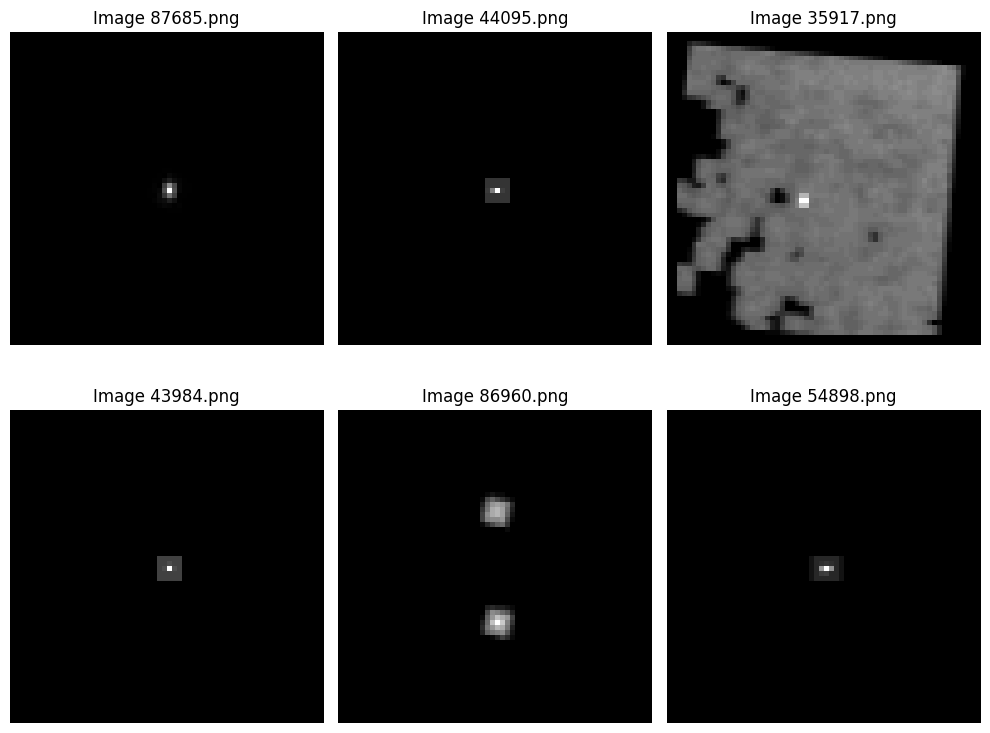

In [455]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for i, ax in enumerate(axes.flatten()):
    random_index = random.randint(0, len(train_loader.dataset))
    image = train_loader.dataset[random_index]
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Image {random_index}.png')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [7]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


## Model with linear layers

Now it's time to create the model which we will train to detect anomalies.
Our sequential models consists of the following:
1. Encoder - reduces dimensionality
2. Decoder - expands dimensionality

#### Encoder architecture
- 5 linear layers (each one gradually reduces dimensionality until reaching size of 4)
- 4 LeakyReLU activation functions. The follow linear layers and introduce non-linearity 

#### Decoder architecture
- 5 linear layers (each one gradually expands dimensionality until reaching size of 4)
- 4 LeakyReLU activation functions. The follow linear layers and introduce non-linearity 
- 1 Sigmoid activation function (Sigmoid), because images are normalized to [0, 1]


In [8]:
class Autoencoder(nn.Module):
    
    def __init__(self):

        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, 512),
            nn.LeakyReLU(True),
            nn.Linear(512, 256),
            nn.LeakyReLU(True), 
            nn.Linear(256, 128),
            nn.LeakyReLU(True),
            nn.Linear(128, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 32),
            nn.LeakyReLU(True),
            nn.Linear(32, 16)
        ) 
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.LeakyReLU(True),
            nn.Linear(32, 64),
            nn.LeakyReLU(True),
            nn.Linear(64, 128),
            nn.LeakyReLU(True), 
            nn.Linear(128, 256),
            nn.LeakyReLU(True),
            nn.Linear(256, 512),
            nn.LeakyReLU(True),
            nn.Linear(512, 64 * 64),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [9]:
model_lin = Autoencoder()
model_lin.to(device).double()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=True)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): LeakyReLU(negative_slope=True)
    (10): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=True)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=True)
    (6): Linear(in_features=128, out_features=256, bias=True)
 

## Model with Convolutional layers
As for the second model, we propose the same architecture as the first one, but instead of using linear layers, we swap them out with Convolutional ones.

Since we're using basically the same architecture, we will have a clear understanding of the differences as well as the similarities of both models.

It will also make the task of comparing them much easier and fair

In [2]:
class AutoencoderConvolutional(nn.Module):

    def __init__(self) -> None:
        
        super(AutoencoderConvolutional, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),  
            nn.LeakyReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
model_conv = AutoencoderConvolutional()
model_conv.to(device).double()

Below we define some training parameters:
- Number of epochs
- Criterion
- Learning rate
- Weight decay
- Optimizer

In [12]:
EPOCHS = 15
CRITERION = nn.MSELoss()
LEARNING_RATE = 1e-3
# Optimizers
OPTIMIZER_LIN = optim.Adam(model_lin.parameters(), lr=LEARNING_RATE)
OPTIMIZER_CONV = optim.Adam(model_conv.parameters(), lr=LEARNING_RATE)


## Model Training

Now we train our model on the given data, with the use of parameters defined above

In [47]:
output_linear = []
losses = []

for e in range(EPOCHS):
    for img in tqdm(train_loader):
        img = img.reshape(-1, 64 * 64)
        recon = model_lin(img)
        loss = CRITERION(recon, img)

        OPTIMIZER_LIN.zero_grad()
        loss.backward()
        OPTIMIZER_LIN.step()
        
    losses.append(loss.item())  
    print(f'Epoch: {e + 1}, Loss: {loss.item():.4f}')
    output_linear.append((e, img, recon))

  0%|          | 0/1547 [00:00<?, ?it/s]

100%|██████████| 1547/1547 [01:33<00:00, 16.61it/s]


Epoch: 1, Loss: 0.0047


100%|██████████| 1547/1547 [01:32<00:00, 16.71it/s]


Epoch: 2, Loss: 0.0022


100%|██████████| 1547/1547 [01:28<00:00, 17.55it/s]


Epoch: 3, Loss: 0.0028


100%|██████████| 1547/1547 [01:33<00:00, 16.63it/s]


Epoch: 4, Loss: 0.0036


100%|██████████| 1547/1547 [01:25<00:00, 18.04it/s]


Epoch: 5, Loss: 0.0011


100%|██████████| 1547/1547 [01:13<00:00, 20.91it/s]


Epoch: 6, Loss: 0.0039


100%|██████████| 1547/1547 [01:21<00:00, 18.98it/s]


Epoch: 7, Loss: 0.0022


100%|██████████| 1547/1547 [01:13<00:00, 21.06it/s]


Epoch: 8, Loss: 0.0026


100%|██████████| 1547/1547 [01:12<00:00, 21.36it/s]


Epoch: 9, Loss: 0.0020


100%|██████████| 1547/1547 [01:23<00:00, 18.57it/s]


Epoch: 10, Loss: 0.0032


100%|██████████| 1547/1547 [01:15<00:00, 20.42it/s]


Epoch: 11, Loss: 0.0041


100%|██████████| 1547/1547 [01:22<00:00, 18.79it/s]


Epoch: 12, Loss: 0.0024


100%|██████████| 1547/1547 [01:24<00:00, 18.32it/s]


Epoch: 13, Loss: 0.0025


100%|██████████| 1547/1547 [01:31<00:00, 16.92it/s]


Epoch: 14, Loss: 0.0027


100%|██████████| 1547/1547 [01:20<00:00, 19.29it/s]

Epoch: 15, Loss: 0.0019


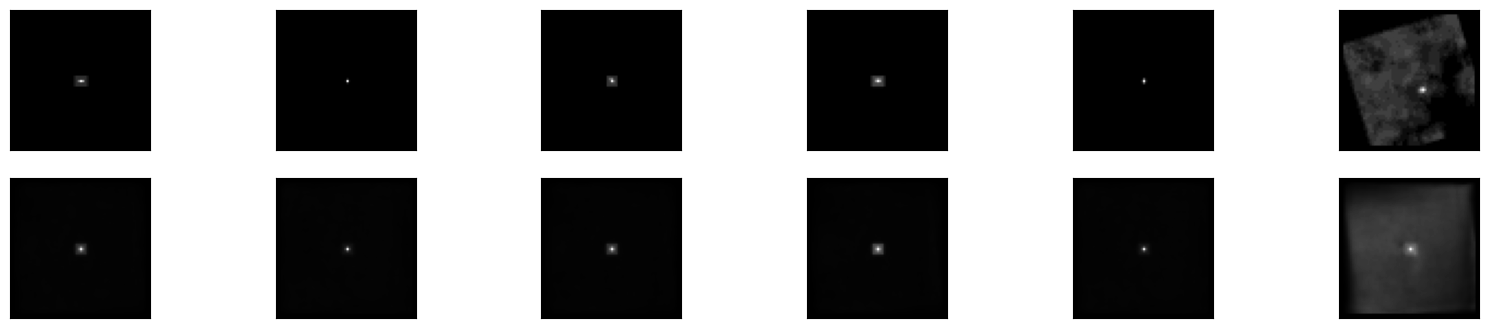

In [50]:
n = 6  # Number of images you want to display
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(64, 64), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i].detach().numpy().reshape(64, 64), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

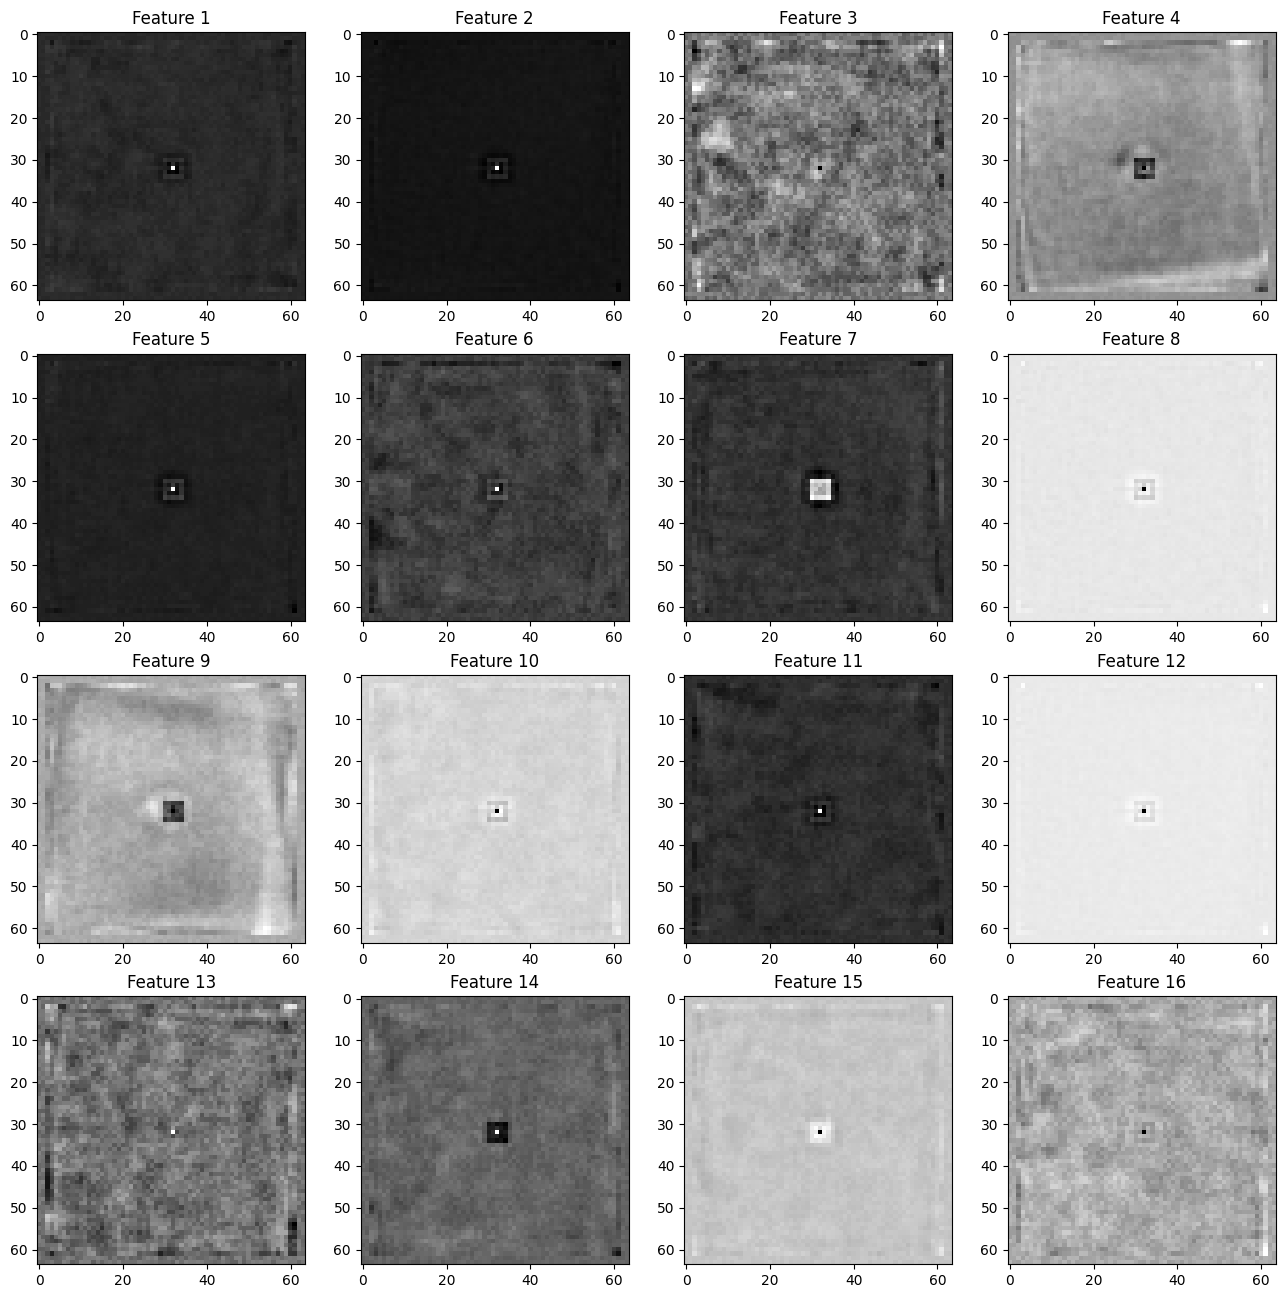

In [55]:
encoder_weights = model_lin.encoder[0].weight.data

num_features_to_visualize = 16
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for i in range(num_features_to_visualize):
    ax = axes[i // 4, i % 4]
    feature = encoder_weights[i].view(64, 64).detach().numpy()
    ax.imshow(feature, cmap='gray')
    ax.set_title(f'Feature {i + 1}')

plt.show()

In [56]:
# Calculate model accuracy
accuracy = sum(reconstruction_error_df['true_class'] == 0) / len(reconstruction_error_df)

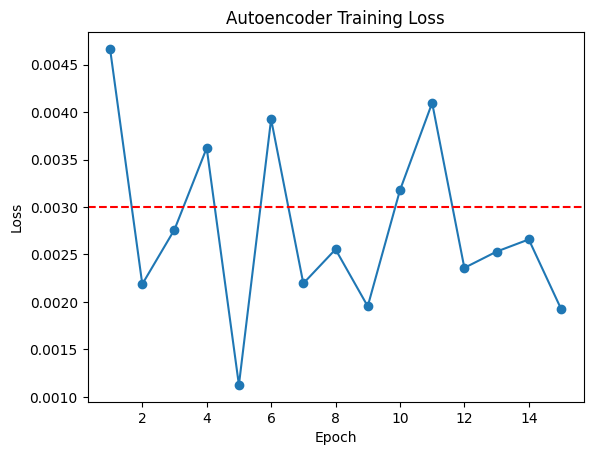

In [60]:
threshold = 0.003

plt.plot(range(1, EPOCHS + 1), losses, marker='o')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [62]:
model_lin.eval()
anomalies = []

for img in test_loader:
    img = img.reshape(-1, 64 * 64)
    recon = model_lin(img)
    loss = CRITERION(recon, img)

    if loss.item() > threshold:
        anomalies.append((img, recon, loss.item()))

len(anomalies)

49

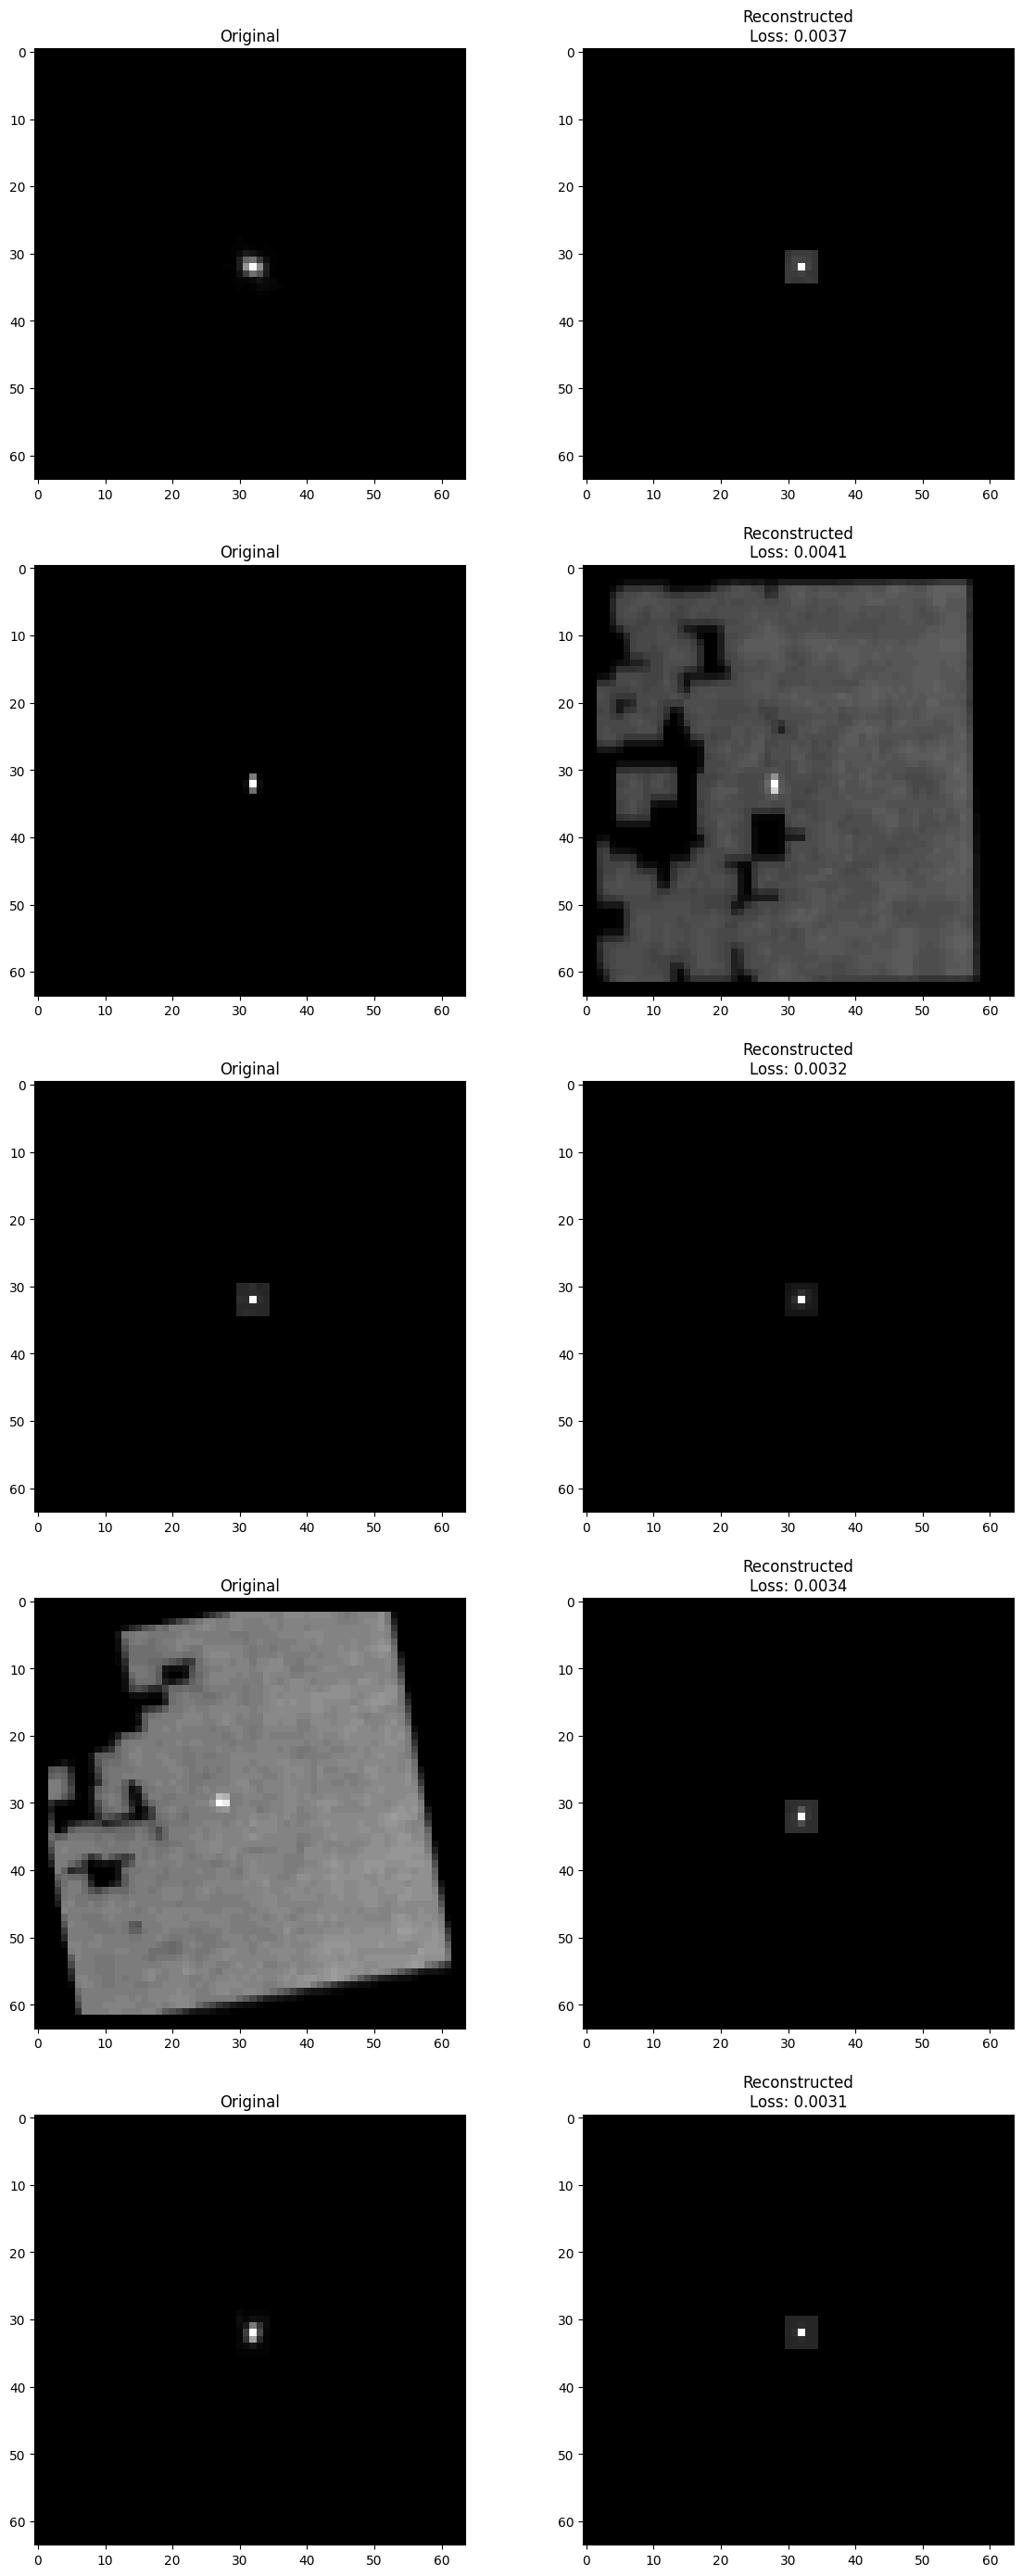

In [69]:
num_anomalies_to_visualize = min(len(anomalies), 5)
fig, axes = plt.subplots(num_anomalies_to_visualize, 2, figsize=(14, 7 * num_anomalies_to_visualize))

for i in range(num_anomalies_to_visualize):
    axes[i, 0].imshow(img[i].view(64, 64).numpy(), cmap='gray')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(anomalies[0][0][i].view(64, 64).detach().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Reconstructed\nLoss: {anomalies[i][2]:.4f}')

plt.show()

<hr>

In [15]:
conv_losses = []
conv_output = []

for epoch in range(EPOCHS):
    for img in tqdm(train_loader):
        # img = img.reshape(-1, 1, 64, 64)
        img = img.unsqueeze(1)
        # Forward pass
        outputs = model_conv(img)

        loss = CRITERION(outputs, img)

        # Backward pass and optimization
        OPTIMIZER_CONV.zero_grad()
        loss.backward()
        OPTIMIZER_CONV.step()
        
    conv_losses.append(loss.item())
    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')
    conv_output.append((epoch, img, outputs))

        

100%|██████████| 1547/1547 [34:58<00:00,  1.36s/it]   


Epoch: 1, Loss: 0.0000


100%|██████████| 1547/1547 [38:43<00:00,  1.50s/it]   


Epoch: 2, Loss: 0.0000


100%|██████████| 1547/1547 [28:17<00:00,  1.10s/it]    


Epoch: 3, Loss: 0.0000


100%|██████████| 1547/1547 [11:41<00:00,  2.21it/s]


Epoch: 4, Loss: 0.0000


100%|██████████| 1547/1547 [11:48<00:00,  2.18it/s]


Epoch: 5, Loss: 0.0000


100%|██████████| 1547/1547 [11:51<00:00,  2.17it/s]


Epoch: 6, Loss: 0.0000


100%|██████████| 1547/1547 [11:52<00:00,  2.17it/s]


Epoch: 7, Loss: 0.0000


100%|██████████| 1547/1547 [1:00:02<00:00,  2.33s/it] 


Epoch: 8, Loss: 0.0000


100%|██████████| 1547/1547 [52:21<00:00,  2.03s/it]    


Epoch: 9, Loss: 0.0000


100%|██████████| 1547/1547 [12:09<00:00,  2.12it/s]


Epoch: 10, Loss: 0.0000


100%|██████████| 1547/1547 [12:02<00:00,  2.14it/s]


Epoch: 11, Loss: 0.0000


100%|██████████| 1547/1547 [11:51<00:00,  2.17it/s]


Epoch: 12, Loss: 0.0000


100%|██████████| 1547/1547 [11:45<00:00,  2.19it/s]


Epoch: 13, Loss: 0.0000


100%|██████████| 1547/1547 [11:42<00:00,  2.20it/s]


Epoch: 14, Loss: 0.0000


100%|██████████| 1547/1547 [1:17:44<00:00,  3.02s/it]    

Epoch: 15, Loss: 0.0000


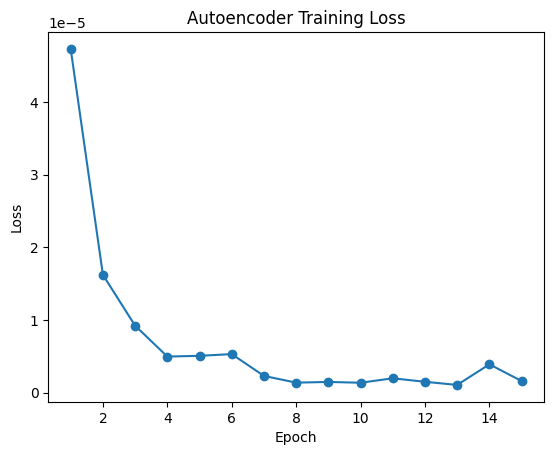

In [30]:
plt.plot(range(1, EPOCHS + 1), conv_losses, marker='o')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [34]:
anomalies = []

In [43]:
for img in test_loader:
    img = img.unsqueeze(1)
    recon = model_conv(img)
    loss = CRITERION(recon, img)

    if loss.item() > 3e-6:
        anomalies.append((img, recon, loss.item()))

In [44]:
len(anomalies)

16

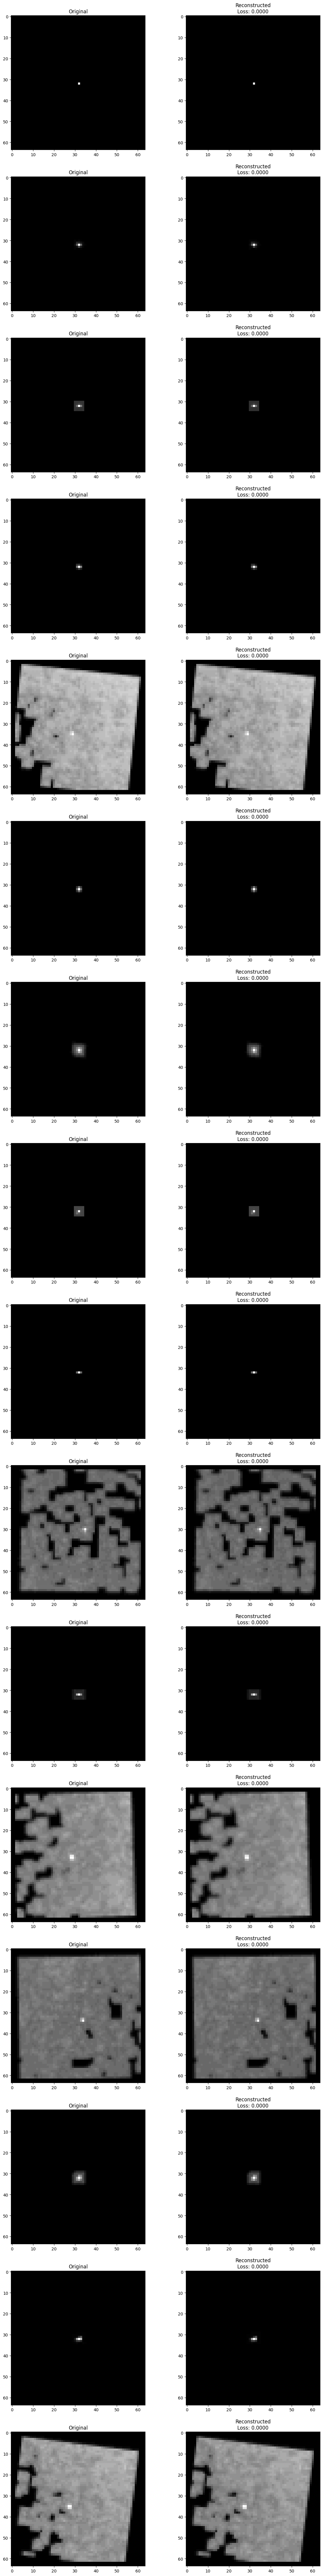

In [51]:
anomlies_to_visualize = min(len(anomalies), 20)

fig, axes = plt.subplots(anomlies_to_visualize, 2, figsize=(14, 7 * anomlies_to_visualize))

for i in range(anomlies_to_visualize):
    axes[i, 0].imshow(anomalies[0][1][i].view(64, 64).detach().numpy(), cmap='gray')
    axes[i, 0].set_title('Original')

    axes[i, 1].imshow(anomalies[0][0][i].view(64, 64).detach().numpy(), cmap='gray')
    axes[i, 1].set_title(f'Reconstructed\nLoss: {anomalies[i][2]:.4f}')

plt.show()

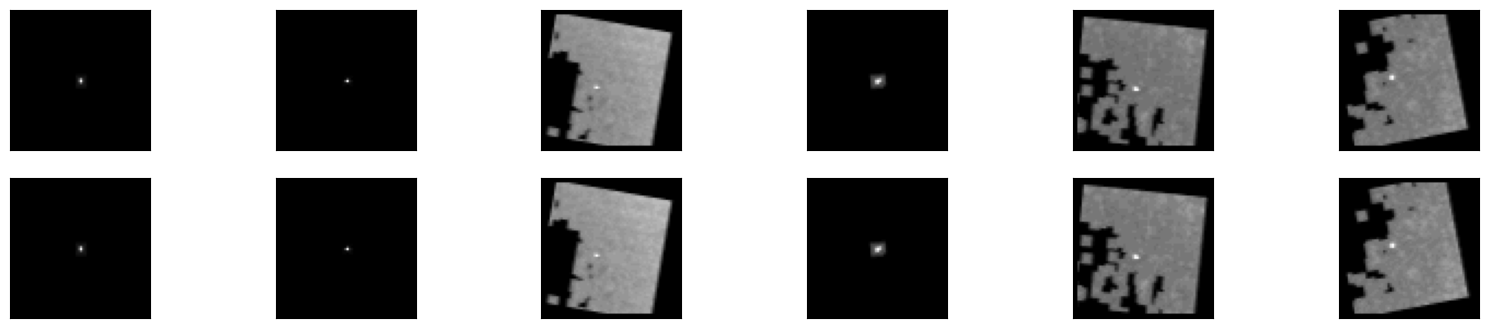

In [23]:
n = 6  # Number of images you want to display
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img[i].reshape(64, 64), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs[i].detach().numpy().reshape(64, 64), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [99]:
# get one image from test set
dataiter = iter(test_loader)
images = dataiter._next_data()
img = images.unsqueeze(1)

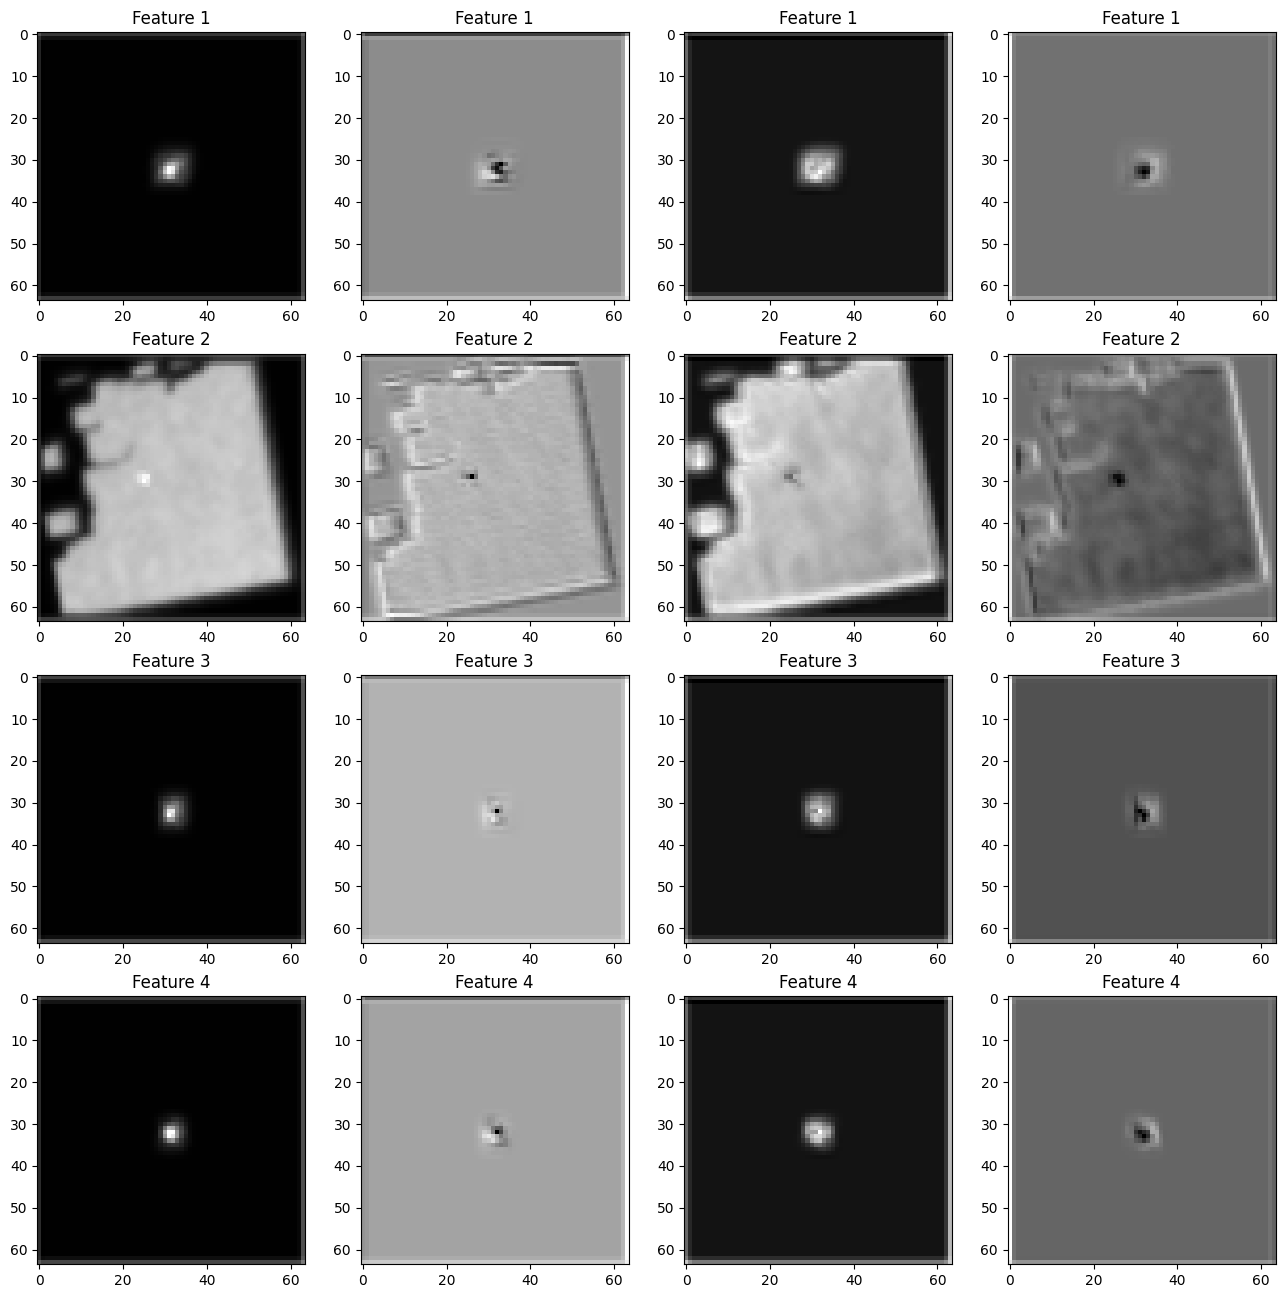

In [100]:
encoder_o = model_conv.encoder(img)
num_f = encoder_o.shape[1]
num_f = min(num_f, 16)

fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(encoder_o[i][j].detach().numpy(), cmap='gray')
        axs[i, j].set_title(f'Feature {i + 1}')
plt.show()

In [106]:
from scipy.stats import zscore

reconstruction_errors = []

# Reconstructed data
for image in test_loader:
    image = image.unsqueeze(1)
    recon = model_conv(image)

    batch_errors = torch.norm(image.view(image.size(0), -1) - recon.view(recon.size(0), -1), dim=1)
    reconstruction_errors.extend(batch_errors.detach().numpy())

z_scores = zscore(reconstruction_errors)

cumulative_z_scores = np.cumsum(z_scores)


In [107]:
print(f'cumulative_z_scores: {cumulative_z_scores}')

cumulative_z_scores: [-5.48499657e-01 -9.11195827e-01 -1.47265995e+00 ...  1.09917093e+00
  6.22988476e-01  6.62470079e-13]


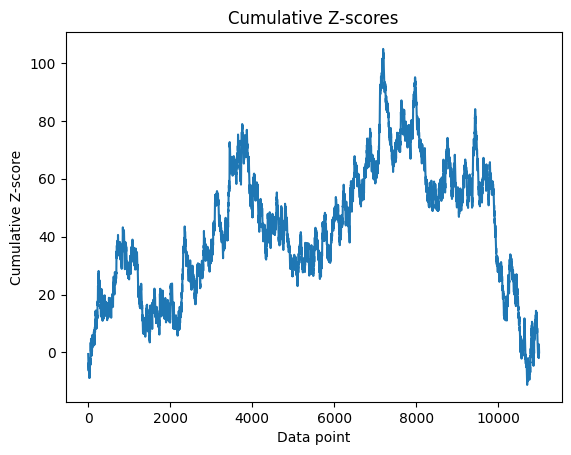

In [108]:
plt.figure()

# Plot the cumulative Z-scores
plt.plot(cumulative_z_scores)

# Add title and labels
plt.title('Cumulative Z-scores')
plt.xlabel('Data point')
plt.ylabel('Cumulative Z-score')

# Show the plot
plt.show()

In [109]:
mse_errors = []

for image in test_loader:
    image = image.unsqueeze(1)
    recon = model_conv(image)

    batch_errors = torch.mean((image.view(image.size(0), -1) - recon.view(recon.size(0), -1)) ** 2, dim=1)
    mse_errors.extend(batch_errors.detach().numpy())

average_mse = np.mean(mse_errors)

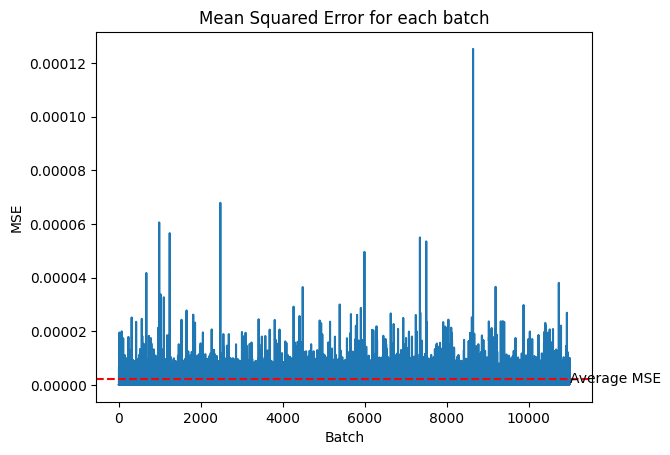

In [110]:
plt.figure()

# Plot the MSE for each batch
plt.plot(mse_errors)

plt.axhline(y=average_mse, color='r', linestyle='--')
plt.text(len(mse_errors), average_mse, 'Average MSE', va='center', ha="left")

# Add title and labels
plt.title('Mean Squared Error for each batch')
plt.xlabel('Batch')
plt.ylabel('MSE')

# Show the plot
plt.show()

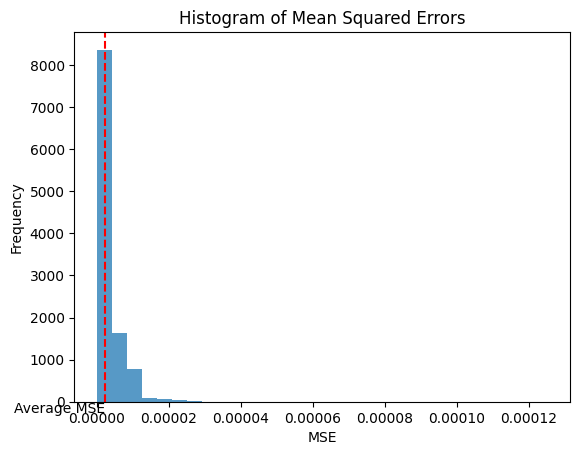

In [112]:
plt.figure()

# Create a histogram of the MSE
plt.hist(mse_errors, bins=30, alpha=0.75)

# Add title and labels
plt.title('Histogram of Mean Squared Errors')
plt.xlabel('MSE')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [114]:
# Define a threshold for the reconstruction error
threshold = np.percentile(mse_errors, 98)  # for example, consider the top 5% of the errors as anomalies

# Calculate the reconstruction accuracy
accuracy = np.mean(mse_errors < threshold)

print(f'Reconstruction accuracy: {accuracy}')

Reconstruction accuracy: 0.98
